In [1]:
import random
import numpy as np
import pandas as pd
#import igraph
import networkx as nx
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv
import re
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from time import time
from nltk import ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sn

# Load data and count nodes

In [2]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]

###################
# random baseline #
###################

#random_predictions = np.random.choice([0, 1], size=len(testing_set))
#random_predictions = zip(range(len(testing_set)),random_predictions)

#with open("random_predictions.csv","w") as pred:
    #csv_out = csv.writer(pred)
    #for row in random_predictions:
        #csv_out.writerow(row)
        
# note: Kaggle requires that you add "ID" and "category" column headers

###############################
# beating the random baseline #
###############################

# the following script gets an F1 score of approximately 0.66

# data loading and preprocessing 

# the columns of the data frame below are: 
# (1) paper unique ID (integer)
# (2) publication year (integer)
# (3) paper title (string)
# (4) authors (strings separated by ,)
# (5) name of journal (optional) (string)
# (6) abstract (string) - lowercased, free of punctuation except intra-word dashes

with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]

with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]

# compute TFIDF vector of each paper
corpus = [element[5] for element in node_info]

# Clean the corpus
def remove_characters(element):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\s?[0-9]+\.?[0-9]*)", " ", element).split())

clean_corpus = []
for sent in corpus:
    clean_corpus.append(remove_characters(sent))
vectorizer = TfidfVectorizer(stop_words="english")
# each row is a node in the order of node_info
features_TFIDF = vectorizer.fit_transform(clean_corpus)

# improving on Tf_idf
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df = 0.1)
features_TFIDF = tfidf_vectorizer.fit_transform(clean_corpus)
features = tfidf_vectorizer.get_feature_names()

top_n = 500

# Rarest words ==> key themes
indices = np.argsort(tfidf_vectorizer.idf_)[::-1]
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

# Frequent words
top_frequent_words = 100
indices_frequent_words = np.argsort(tfidf_vectorizer.idf_)[::1]
frequent_features = [features[i] for i in indices_frequent_words[:top_frequent_words]]

# In the end, list of words to remove: 
words_abstract_to_remove = frequent_features + list(stpwds)

## the following shows how to construct a graph with igraph
## even though in this baseline we don't use it
## look at http://igraph.org/python/doc/igraph.Graph-class.html for feature ideas

edges = [(element[0],element[1]) for element in training_set if element[2]=="1"]

## some nodes may not be connected to any other node
## hence the need to create the nodes of the graph from node_info.csv,
## not just from the edge list

nodes = IDs

## create empty directed graph
g = nx.DiGraph()
 
## add vertices
g.add_nodes_from(nodes)
 
## add edges
g.add_edges_from(edges)

# In-degree and out-degree for all the list of nodes contained in the node_info file
#degree = g.degree()
in_degree = g.in_degree()
out_degree = g.out_degree()

degree_by_node = list(zip(nodes, in_degree.values(), out_degree.values()))
#in_degree.values(),
#out_degree.values()))

#degree centrality
out_degree_centrality = nx.out_degree_centrality(g)
in_degree_centrality = nx.in_degree_centrality(g)

# closeness_centrality
closeness_centrality = nx.closeness_centrality(g)

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(g)

#Page rank
page_rank = nx.pagerank(g)

[nltk_data] Downloading package punkt to /Users/victort-d/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/victort-d/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['pesando', 'govindarajan', 'perron', 'perplexing', 'perpetuum', 'perpetual', 'gowdy', 'cmn', 'goyaks', 'permuting', 'gozzi', 'cmr', 'gpi', 'permutability', 'perms', 'gpp', 'permitivity', 'permisible', 'permettant', 'persence', 'persistance', 'permeates', 'eigenspinors', 'perturbativity', 'perturbatives', 'clovis', 'perturbativelly', 'perturbativally', 'perturbational', 'perturbaive', 'clumped', 'clumping', 'pertinence', 'pertinant', 'perth', 'clumsy', 'personally', 'personality', 'government', 'clylindrical', 'permeating', 'coadditive', 'eightbranes', 'perevalov', 'gracey', 'perelo', 'pereira', 'cobicross', 'percolating', 'perceptions', 'perception', 'percentage', 'grad', 'perceives', 'peoples', 'penteli', 'pentagrams', '

In [21]:
np.argsort(tfidf_vectorizer.idf_)

array([15221,  3120,  8304, ..., 14557,  8197, 14602])

# Train set

In [3]:
# for each training example we need to compute features
# in this baseline we will train the model on only 5% of the training set

# randomly select 5% of training set
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.5)))
training_set_reduced = [training_set[i] for i in to_keep]

# we will use three basic features:

# number of overlapping words in title
overlap_title = []

# temporal distance between the papers
temp_diff = []

# number of common authors
comm_auth = []

# common terms in abstract
comm_terms_abstract = []
nb_words_common_abstract = []

# Common words in revie titles
nb_words_common_reviews = []

# List contains sums, for each pair (source, target), the out-degree of the source node and the in-degree of the target
degree_relation = []

# List the preferential attachement for each pair (source, target)
preferential_attachment = []

# Common neighbors score for each pair (source,target)
common_neighbors_score = []

#Centrality
in_degree_centrality_diff = []
out_degree_centrality_diff = []
rel_degree_centrality = []
betweenness_centrality_diff = []
closeness_centrality_diff = []

#page_rank
page_rank_source = []
page_rank_target = []
pagerank_diff = []

#jaccard and adar scores
jaccard_score = []
adar_score = []

# Jaccard similarity
def predict(u, v):
    cnbors = list(nx.common_neighbors(G, u, v))
    union_size = len(set(G[u]) | set(G[v]))
    if union_size == 0:
        return 0
    else:
        return len(cnbors) / union_size


# Jaccard similarity
def jaccard_similarity(node1, node2):
    """Returns the Jaccard similarity between the two given vertices,
    assuming that both of them are linked to themselves."""
    # Retrieve the common neighbors for each of the 27,770 different nodes
    #list_neighbors = [set(g.neighbors(i)).union([i]) for i in g.nodes()]
    set1, set2 = set(g.neighbors(node1)), set(g.neighbors(node2))
    isect = len(set1.intersection(set2))
    return isect / (len(set1) + len(set2) - isect + 0.0000001)

# adamic_adar
def adamic_adar(node1, node2):
    """Returns the adamic/Adar value of two nodes"""
    # Retrieve the common neighbors for each of the 27,770 different nodes
    #list_neighbors = [set(g.neighbors(i)).union([i]) for i in g.nodes()]
    set1, set2 = set(g.neighbors(node1)), set(g.neighbors(node2))
    intersec = set1.intersection(set2)
    adar = 0
    #if len(intersec) != 0:
    for i in intersec:
        adar += 1/(np.log(len(set(g.neighbors(i)))+ 0.0000001) + 0.0000001)
        
    return adar


counter = 0
for i in range(len(training_set_reduced)):
    source = training_set_reduced[i][0]
    target = training_set_reduced[i][1]
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    
    source_info = [element for element in node_info if element[0]==source][0]
    target_info = [element for element in node_info if element[0]==target][0]
    
	# convert to lowercase and tokenize
    source_title = source_info[2].lower().split(" ")
	# remove stopwords
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
    
    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",")
    
    overlap_title.append(len(set(source_title).intersection(set(target_title))))
    temp_diff.append(int(source_info[1]) - int(target_info[1]))
    comm_auth.append(len(set(source_auth).intersection(set(target_auth))))
 
    # Common words in abstract
    source_abstract = source_info[5].lower().split(" ")
    source_abstract = [token for token in source_abstract if token not in words_abstract_to_remove]
    source_abstract = [stemmer.stem(token) for token in source_abstract]
    source_abstract = [remove_characters(token) for token in source_abstract]
    target_abstract = target_info[5].lower().split(" ")
    target_abstract = [token for token in target_abstract if token not in words_abstract_to_remove]
    target_abstract = [stemmer.stem(token) for token in target_abstract]
    target_abstract = [remove_characters(token) for token in target_abstract]
    #comm_terms_abstract.append(set(source_abstract).intersection(set(target_abstract)))
    nb_words_common_abstract.append(len(set(source_abstract).intersection(set(target_abstract))))
    
    # Jaccard similarity
    #jaccard_sim.append(igraph.Graph.similarity_jaccard(vertices = None, pairs = (source,target), mode = all, loops = False))
    
    # Common reviews
    source_reviews = source_info[4].lower().split(".")
    source_reviews = [token for token in source_reviews if token not in stpwds]
    source_reviews = [stemmer.stem(token) for token in source_reviews]
    target_reviews = target_info[4].lower().split(".")
    target_reviews = [token for token in target_reviews if token not in stpwds]
    target_reviews = [stemmer.stem(token) for token in target_reviews]
    nb_words_common_reviews.append(len(set(source_reviews).intersection(set(target_reviews))))   
    
    # Sum of in-degree for source node + out-degree for target node
    degree_relation.append(degree_by_node[index_source][1] + degree_by_node[index_target][1])
  
    #Preferential attachment score between nodes source and target in a graph g
    preferential_attachment.append(len(g.neighbors(source))*len(g.neighbors(target)))
    preferential_attachment.append(out_degree(source)*in_degree(target))
    
    
    #Common neighbors score between nodes source and target in a graph g
    common_neighbors_score.append(len(g.neighbors(source) and g.neighbors(target)))
    
    #Jaccard similarity score
    jaccard_score.append(jaccard_similarity(source, target)) 
    
    #Adamic-Adar score
    adar_score.append(adamic_adar(source, target))
    
    #Degree centrality
    in_degree_centrality_diff.append(in_degree_centrality[source] - in_degree_centrality[target])
    out_degree_centrality_diff.append(out_degree_centrality[source] - out_degree_centrality[target])
    
    rel_degree_centrality.append(out_degree_centrality[source] + in_degree_centrality[target])
    betweenness_centrality_diff.append(betweenness_centrality[source] - betweenness_centrality[target] )
    closeness_centrality_diff.append(closeness_centrality[source] - closeness_centrality[target] )
    
    #page_rank
    page_rank_source.append(page_rank[source])
    page_rank_target.append(page_rank[target])
    pagerank_diff.append(page_rank[source] - page_rank[target])

    counter += 1
    if counter % 1000 == True:
        print(counter, "training examples processsed")

1 training examples processsed
1001 training examples processsed
2001 training examples processsed
3001 training examples processsed
4001 training examples processsed
5001 training examples processsed
6001 training examples processsed
7001 training examples processsed
8001 training examples processsed
9001 training examples processsed
10001 training examples processsed
11001 training examples processsed
12001 training examples processsed
13001 training examples processsed
14001 training examples processsed
15001 training examples processsed
16001 training examples processsed
17001 training examples processsed
18001 training examples processsed
19001 training examples processsed
20001 training examples processsed
21001 training examples processsed
22001 training examples processsed
23001 training examples processsed
24001 training examples processsed
25001 training examples processsed
26001 training examples processsed
27001 training examples processsed
28001 training examples processse

231001 training examples processsed
232001 training examples processsed
233001 training examples processsed
234001 training examples processsed
235001 training examples processsed
236001 training examples processsed
237001 training examples processsed
238001 training examples processsed
239001 training examples processsed
240001 training examples processsed
241001 training examples processsed
242001 training examples processsed
243001 training examples processsed
244001 training examples processsed
245001 training examples processsed
246001 training examples processsed
247001 training examples processsed
248001 training examples processsed
249001 training examples processsed
250001 training examples processsed
251001 training examples processsed
252001 training examples processsed
253001 training examples processsed
254001 training examples processsed
255001 training examples processsed
256001 training examples processsed
257001 training examples processsed
258001 training examples pro

In [38]:
counter = 0
preferential_attachment2 = []
rel_degree_centrality2 = []
pagerank_sum = []
for i in range(len(training_set_reduced)):  
    source = training_set_reduced[i][0]
    target = training_set_reduced[i][1] 
    
    preferential_attachment2.append(out_degree[source]*out_degree[target])
    
    rel_degree_centrality2.append(out_degree_centrality[source] - in_degree_centrality[target])
    
    pagerank_sum.append(page_rank[source] + page_rank[target])

    counter += 1
    if counter % 1000 == True:
        print(counter, "training examples processsed")

1 training examples processsed
1001 training examples processsed
2001 training examples processsed
3001 training examples processsed
4001 training examples processsed
5001 training examples processsed
6001 training examples processsed
7001 training examples processsed
8001 training examples processsed
9001 training examples processsed
10001 training examples processsed
11001 training examples processsed
12001 training examples processsed
13001 training examples processsed
14001 training examples processsed
15001 training examples processsed
16001 training examples processsed
17001 training examples processsed
18001 training examples processsed
19001 training examples processsed
20001 training examples processsed
21001 training examples processsed
22001 training examples processsed
23001 training examples processsed
24001 training examples processsed
25001 training examples processsed
26001 training examples processsed
27001 training examples processsed
28001 training examples processse

# Classification Algorithms

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
training_features = np.array([overlap_title, temp_diff, comm_auth, nb_words_common_abstract, nb_words_common_reviews, degree_relation, preferential_attachment,preferential_attachment2, common_neighbors_score, jaccard_score, adar_score, in_degree_centrality_diff, out_degree_centrality_diff, rel_degree_centrality, betweenness_centrality_diff, closeness_centrality_diff, page_rank_source, page_rank_target, pagerank_diff]).T
training_features1 = training_features[:275000]
training_features2 = training_features[275000:]

# scale
training_features1 = preprocessing.scale(training_features1)
training_features2 = preprocessing.scale(training_features2)

# convert labels into integers then into column array
labels = [int(element[2]) for element in training_set_reduced]
labels = list(labels)
labels_array = np.array(labels)

labels_array1 = labels_array[:275000]
labels_array2 = labels_array[275000:]

# initialize basic SVM
classifier = svm.LinearSVC(C= 100)

# train
classifier.fit(training_features1, labels_array1)
classifier.score(training_features2, labels_array2)
pred = classifier.predict(training_features2)
Confus_svm = confusion_matrix(labels_array2, pred)

Confusion matrix, without normalization
[[12978  1957]
 [ 1184 16637]]


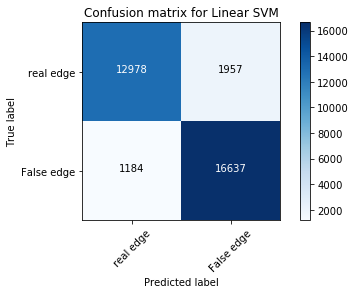

In [24]:
class_names = ["real edge", "False edge"]

plt.figure()
plot_confusion_matrix(Confus_svm, classes=class_names,
                      title='Confusion matrix for Linear SVM')

plt.savefig('cm_SVM.pdf')

In [46]:
# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
training_features = np.array([overlap_title, temp_diff, comm_auth, nb_words_common_abstract, nb_words_common_reviews, degree_relation, preferential_attachment, common_neighbors_score, jaccard_score, adar_score, rel_degree_centrality, rel_degree_centrality2, betweenness_centrality_diff, closeness_centrality_diff, pagerank_sum, pagerank_diff]).T
training_features1 = training_features[:275000]
training_features2 = training_features[275000:]

# scale
training_features1 = preprocessing.scale(training_features1)
training_features2 = preprocessing.scale(training_features2)

# convert labels into integers then into column array
labels = [int(element[2]) for element in training_set_reduced]
labels = list(labels)
labels_array = np.array(labels)

labels_array1 = labels_array[:275000]
labels_array2 = labels_array[275000:]

# Load RandomForest

classifier2 = RandomForestClassifier(bootstrap = False, criterion = 'entropy', max_depth = None , max_features = 7, min_samples_leaf =7, min_samples_split = 10)

# train
classifier2.fit(training_features1, labels_array1)
classifier2.score(training_features2, labels_array2)
#pred2 = classifier2.predict(training_features2)
#Confus_rdf = confusion_matrix(labels_array2, pred2)

0.94285016485529372

In [14]:
classifier2.score(training_features2, labels_array2)

0.94263646354866282

Confusion matrix, without normalization
[[14144   791]
 [ 1188 16633]]


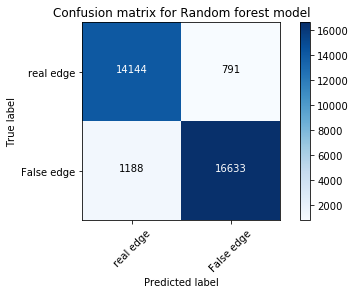

In [29]:
class_names = ["real edge", "False edge"]

plt.figure()
plot_confusion_matrix(Confus_rdf, classes=class_names,
                      title='Confusion matrix for Random forest model')

plt.savefig('cm_rdf.pdf')

In [19]:
# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
training_features = np.array([overlap_title, temp_diff, comm_auth, nb_words_common_abstract, nb_words_common_reviews, degree_relation, preferential_attachment, common_neighbors_score, jaccard_score, adar_score, in_degree_centrality_diff, out_degree_centrality_diff, rel_degree_centrality, page_rank_source, page_rank_target, betweenness_centrality_diff, closeness_centrality_diff, pagerank_diff]).T
training_features1 = training_features[:275000]
training_features2 = training_features[275000:]

# scale
training_features1 = preprocessing.scale(training_features1)
training_features2 = preprocessing.scale(training_features2)

# convert labels into integers then into column array
labels = [int(element[2]) for element in training_set_reduced]
labels = list(labels)
labels_array = np.array(labels)

labels_array1 = labels_array[:275000]
labels_array2 = labels_array[275000:]

# Load RandomForest

classifier3 = LogisticRegression(C = 1000, penalty = 'l2')

# train
classifier3.fit(training_features1, labels_array1)
classifier3.score(training_features2, labels_array2)
pred3 = classifier3.predict(training_features2)
Confus_lr = confusion_matrix(labels_array2, pred3)

Confusion matrix, without normalization
[[13977   958]
 [ 1705 16116]]


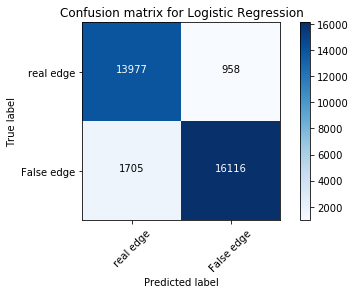

In [21]:
class_names = ["real edge", "False edge"]

plt.figure()
plot_confusion_matrix(Confus_lr, classes=class_names,
                      title='Confusion matrix for Logistic Regression')

plt.savefig('cm_lr.pdf')

## Optimisation of hyper parameters - Grid search

In [52]:
param_grid_SVC = {'C':[1,10,100,1000], 'kernel':'linear'}
model_SVC = GridSearchCV(classifier, param_grid=param_grid_SVC)
model_SVC.fit(training_features1, labels_array1)
start = time()

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(model_lr.cv_results_['params'])))

NameError: name 'classifier' is not defined

In [ ]:
model_SVC.best_params_

In [11]:
# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 5, 7, 9],
              "min_samples_split": [2, 3, 7, 13, 20],
              "min_samples_leaf": [1, 3, 5, 9, 13, 20],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(classifier2, param_grid=param_grid)
grid_search.fit(training_features1, labels_array1)
start = time()

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

KeyboardInterrupt: 

In [12]:
grid_search.best_params_

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [16]:
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
model_lr = GridSearchCV(classifier3, param_grid=grid_values)
model_lr.fit(training_features1, labels_array1)
start = time()

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(model_lr.cv_results_['params'])))

GridSearchCV took 0.00 seconds for 14 candidate parameter settings.


In [17]:
model_lr.best_params_

{'C': 1000, 'penalty': 'l2'}

# Test Set

In [ ]:
# test
# we need to compute the features for the testing set

overlap_title_test = []
temp_diff_test = []
comm_auth_test = []
# common terms in abstract
comm_terms_abstract_test = []
nb_words_common_abstract_test = []

# Common words in revie titles
comm_terms_reviews_test = []
nb_words_common_reviews_test = []
  
# List contains sums, for each pair (source, target), the out-degree of the source node and the in-degree of the target
degree_relation_test = []

# List the preferential attachement for each pair (source, target)
preferential_attachment_test = []

# Common neighbors score for each pair (source,target)
common_neighbors_score_test = []
jaccard_score_test = []
adar_score_test = []

#degree centrality
in_degree_centrality_diff_test = []
out_degree_centrality_diff_test = []
rel_degree_centrality_test = []
betweenness_centrality_diff_test = []
closeness_centrality_diff_test = []


#page rank
page_rank_source_test = []
page_rank_target_test = []
pagerank_diff_test = []


counter = 0
for i in range(len(testing_set)):
    source = testing_set[i][0]
    target = testing_set[i][1]
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    
    #source = training_set_reduced[i][0]
    #target = training_set_reduced[i][1]
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    
    source_info = [element for element in node_info if element[0]==source][0]
    target_info = [element for element in node_info if element[0]==target][0]
    
    source_title = source_info[2].lower().split(" ")
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
    
    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",")
    
    overlap_title_test.append(len(set(source_title).intersection(set(target_title))))
    temp_diff_test.append(int(source_info[1]) - int(target_info[1]))
    comm_auth_test.append(len(set(source_auth).intersection(set(target_auth))))
    
    # Common words in abstract
    source_abstract = source_info[5].lower().split(" ")
    source_abstract = [token for token in source_abstract if token not in stpwds]
    source_abstract = [stemmer.stem(token) for token in source_abstract]
    target_abstract = target_info[5].lower().split(" ")
    target_abstract = [token for token in target_abstract if token not in stpwds]
    target_abstract = [stemmer.stem(token) for token in target_abstract]
    #comm_terms_abstract_test.append(set(source_abstract).intersection(set(target_abstract)))
    nb_words_common_abstract_test.append(len(set(source_abstract).intersection(set(target_abstract))))
    
    # Jaccard similarity
    #jaccard_sim.append(igraph.Graph.similarity_jaccard(vertices = None, pairs = (source,target), mode = all, loops = False))
    
    # Common reviews
    source_reviews = source_info[4].lower().split(".")
    source_reviews = [token for token in source_reviews if token not in stpwds]
    source_reviews = [stemmer.stem(token) for token in source_reviews]
    target_reviews = target_info[4].lower().split(".")
    target_reviews = [token for token in target_reviews if token not in stpwds]
    target_reviews = [stemmer.stem(token) for token in target_reviews]
    #comm_terms_reviews_test.append(set(source_reviews).intersection(set(target_reviews)))
    nb_words_common_reviews_test.append(len(set(source_reviews).intersection(set(target_reviews))))   
    
    # Sum of in-degree for source node + out-degree for target node
    degree_relation_test.append(degree_by_node[index_source][2] + degree_by_node[index_target][1])
  
    #Preferential attachment score between nodes source and target in a graph g
    preferential_attachment_test.append(len(g.neighbors(source))*len(g.neighbors(target)))
    
    #Common neighbors score between nodes source and target in a graph g
    common_neighbors_score_test.append(len(g.neighbors(source) and g.neighbors(target)))
    
    jaccard_score_test.append(jaccard_similarity(source, target))  
    
    adar_score_test.append(adamic_adar(source, target)) 
    
    #Degree centrality
    in_degree_centrality_diff_test.append(in_degree_centrality[source] - in_degree_centrality[target])
    out_degree_centrality_diff_test.append(out_degree_centrality[source] - out_degree_centrality[target])
    rel_degree_centrality_test.append(out_degree_centrality[source] + in_degree_centrality[target])
    betweenness_centrality_diff_test.append(betweenness_centrality[source] - betweenness_centrality[target] )
    closeness_centrality_diff_test.append(closeness_centrality[source] - closeness_centrality[target] )

    #page_rank
    page_rank_source_test.append(page_rank[source])
    page_rank_target_test.append(page_rank[target])
    pagerank_diff_test.append(page_rank[source] - page_rank[target] )
    
       
    counter += 1
    if counter % 1000 == True:
        print(counter, "testing examples processsed")
        

In [ ]:
# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
testing_features = np.array([overlap_title_test, temp_diff_test, comm_auth_test, nb_words_common_abstract_test, nb_words_common_reviews_test, degree_relation_test, preferential_attachment_test, common_neighbors_score_test, jaccard_score_test, adar_score_test, in_degree_centrality_diff_test, out_degree_centrality_diff_test, rel_degree_centrality_test, page_rank_source_test, page_rank_target_test, betweenness_centrality_diff_test, closeness_centrality_diff_test, pagerank_diff_test] ).T

# scale
testing_features = preprocessing.scale(testing_features)

# issue predictions
predictions_SVM = list(classifier2.predict(testing_features))

# write predictions to .csv file suitable for Kaggle (just make sure to add the column names)
predictions_SVM = zip(range(len(testing_set)), predictions_SVM)

with open("improved_predictions.csv","w") as pred1:
    csv_out = csv.writer(pred1)
    for row in predictions_SVM:
        csv_out.writerow(row)

In [8]:
f = 1 - abs(0.1 - 0.20911)/float(2.0)
f

0.945445

In [ ]:
G['5988']